### Main imports

In [80]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import mantis.rock_physics as manRP

### Class for exporting grids

In [81]:
from __future__ import annotations
from typing import Callable
import os
class FiniteDifferenceGridFromRockPhysicsModels:
    """
    Generates binary grids for finite difference modelling

    Generates binary grids for finite difference modelling from a dictionary of rock physics models and a dictionary of well inputs
    
    """
    indices = {
        "a11":(0,0),
        "a33":(2,2),
        "a13":(0,2),
        "a55":(4,4),
        "a15":(0,4),
        "a35":(2,4),
        "a66":(5,5),
        "a44":(3,3),
        "a64":(5,3)
}
    def __init__(self, *, well_input:dict, mod_dictionary:dict, label:str=""):
        """
        Instantiates a FiniteDifferenceGridFromRockPhysicsModels object for generating binary grids for finite difference modelling

        Args:
            well_input (dict): well inputs in the form: {layer_number:{"Top Depth": 0, "Vp": 2., "Vs": 1., "Rho": 2.} ...}
            mod_dictionary (dict): model input in the form {layer_number:{"model": model_id, "parameters": {"parameter1": value1, "parameter2": value2} ...} ...}}}
                    where `model_id` is an identifier for a rock physics model in the model library and `parameteri` are parameters for the model
            label (str, optional): a label for the model which is used in file exports. If no label is given (default) the binary grids are written in ./_output folder. Defaults to "".

        Raises:
            ValueError: _description_
            KeyError: _description_
        """
        self.well_input = dict(sorted(well_input.items(), key=lambda item: item[1]["Top Depth"]))
        self.model_dictionary = mod_dictionary
        if well_input.keys() != mod_dictionary.keys():
            raise ValueError("well_input and mod_dictionary must have the same layer keys")
        self._model_list = None
        self._grid_data = None
        self._grid_metadata = None
        self.label = label
        self.depth_list, self.vp_list, self.vs_list, self.rho_list = self.create_vp_vs_rho_list
    
    @property
    def create_vp_vs_rho_list(self) -> tuple:
        depth_list = []
        vp_list = []
        vs_list = []
        rho_list = []
        for key, val in self.well_input.items():
            try:
                depth_list.append(val["Top Depth"])
            except:
                KeyError("`Top Depth` key not found")
            try:
                vp_list.append(val["Vp"])
            except:
                KeyError("`Vp` key not found")
            try:
                vs_list.append(val["Vs"])
            except:
                KeyError("`Vs` key not found")
            try:
                rho_list.append(val["Rho"])
            except:
                KeyError("`Rho` key not found")
        return np.array(depth_list), np.array(vp_list), np.array(vs_list), np.array(rho_list)
    
    def create_model_list(self):
        if self._model_list is None:
            self._model_list = {}
        for key, val in self.well_input.items():
            # error prone
            temp_params = dict(**val, **self.model_dictionary[key]["parameters"])
            temp_model = self.model_dictionary[key]["model"]
            # print("why?")
            try:
                init_model = manRP.models(identifier= temp_model, **temp_params)
            except:
                raise ValueError("model not found")
            self._model_list[key] = init_model

    @property
    def model_list(self):
        if self._model_list is None:
            self.create_model_list()
        return self._model_list
    
    def to_aij_density(self):
        result = {}
        for i, m in self.model_list.items():
            if m.__repr__()== "Generic Rock Physics Model":
                result[i] = {'aij': m.Cij()/self.rho_list[i]*10**6, 'rho': self.rho_list[i]*1000, 'tau_eps_d': 1, 'tau_eps_s': 1, 'tau_sig_d': 1, 'tau_sig_s': 1}
            elif m.__repr__()== "Standard Linear Solid Rock Physics Model":
                result[i] = {'aij': m.high_freq_cij/self.rho_list[i]*10**6, 'rho': self.rho_list[i]*1000, 'tau_eps_d': m.tau1, 'tau_eps_s': m.tau1, 'tau_sig_d': m.tau2, 'tau_sig_s': m.tau2}
            else:
                raise ValueError("model not supported yet, check back later")
        return result
    
    def gaussian_smoothing(self, size:int, sigma:float)->Callable:
        def gf(x, sig): return (1 / (np.sqrt(2 * np.pi * sigma**2))) * np.exp(-(x**2) / (2 * sigma**2))
        zero_centred = np.arange(-(size // 2), (size // 2) + 1)
        g_filter = gf(zero_centred, sigma)
        g_filter /= np.sum(g_filter) # for normalisation, maybe peak being 1 is better?
        return lambda x: np.convolve(x, g_filter, mode='same')

    def create_modelling_grids(self, *, n_x_grid_points:int=2001, n_z_grid_points:int=1126, dx:int=2, offset:float = 500., smoothing_function:Callable|None=None) -> dict:
        """
        creates a dictionary of grids for finite difference modelling

        evaluates the well inputs at the specified vertical grid points and extents laterally to a 1D model

        Keyword Args:
            n_x_grid_points (int, optional): _description_. Defaults to 2001.
            n_z_grid_points (int, optional): _description_. Defaults to 1126.
            dx (int, optional): _description_. Defaults to 2.
            offset (float, optional): _description_. Defaults to 500.
            smoothing_function (Callable | None, optional): _description_. Defaults to None.

        Returns:
            dict: a dictionary whose keys are grid name variables and values are a 2D array of corresponding grid values
        """
        vertical = dx*np.arange(n_z_grid_points)
        aij_array = np.zeros((n_z_grid_points, 6, 6), dtype=np.single)
        rho_array, tau_eps_d_array, tau_eps_s_array, tau_sig_d_array, tau_sig_s_array = tuple(np.zeros((n_z_grid_points), dtype=np.single) for i in range(5))
        dl = self.depth_list
        well_dictionary = self.to_aij_density()
        for i, depth in enumerate(dl):
            if i==0:
                index = (depth<=vertical)
            elif i==len(dl)-1:
                index = (depth<=vertical-offset)
            else:
                index = (depth<=vertical-offset) & (vertical-offset<dl[i+1])
            
            aij_array[index] = well_dictionary[i]['aij']
            rho_array[index] = well_dictionary[i]['rho']
            tau_eps_d_array[index] = well_dictionary[i]['tau_eps_d']
            tau_eps_s_array[index] = well_dictionary[i]['tau_eps_s']
            tau_sig_d_array[index] = well_dictionary[i]['tau_sig_d']
            tau_sig_s_array[index] = well_dictionary[i]['tau_sig_s']

        # to implement smoothing add some sort of line:
        # try:
        #   smoothing_function(aij_array)
        # except:
        #   raise ValueError("smoothing_function not callable")

        # to repeat values along the x axis, n_x_grid_points times
        def tile_x(x): return np.tile(x, (n_x_grid_points, 1)).T

        # repeat the values along x for each of the indices in the dictionary
        result = {key:tile_x(aij_array[:,value[0], value[1]])  for key, value in FiniteDifferenceGridFromRockPhysicsModels.indices.items()}
        
        density_tau_dictionary = {"density": rho_array, "tau_eps_d": tau_eps_d_array, "tau_eps_s": tau_eps_s_array, "tau_sig_d": tau_sig_d_array, "tau_sig_s": tau_sig_s_array}
        for key, value in density_tau_dictionary.items():
            result[key] = tile_x(value)
        for key, value in result.items():
            if value.shape != (n_z_grid_points, n_x_grid_points):
                raise ValueError(f"shape of {key} is {value.shape}, not {(n_x_grid_points, n_z_grid_points)}")
        return result

    def save_modelling_grids(self, *, output_folder:str|None =None, **kwargs)->None:
        """
        save_modelling_grids saves the individual grids to files in a specified folder

        Keyword Args:
            output_folder (str | None, optional): _description_. Defaults to None.
            n_x_grid_points (int, optional): _description_. Defaults to 2001.
            n_z_grid_points (int, optional): _description_. Defaults to 1126.
            dx (int, optional): _description_. Defaults to 2.
            offset (float, optional): _description_. Defaults to 500..
            smoothing_function (Callable | None, optional): _description_. Defaults to None.   
        """
        if output_folder is None:
            Warning(f"output_folder not specified, using {self.label}_output in current directory ")
            output_folder = f"./{self.label}_output"
        if not os.path.exists(output_folder):
            print(f"creating folder {output_folder}")
            os.makedirs(output_folder)
        grids = self.create_modelling_grids(**kwargs)
        for key, value in grids.items():
            value.tofile(f"{output_folder}/{key}.bin")

### Usage

first load some data from well log inputs

In [82]:
with open('./input_data/balgonie_dataset.bin','rb') as f:
    depth = np.fromfile(f,dtype=np.dtype('int32'),count=1)[0]
    dims = np.fromfile(f,dtype=np.dtype('int32'),count=depth)
    total_elements = (lambda x,y:x*y)(*dims)
    data =np.reshape(np.fromfile(f,dtype=np.dtype('float64'), count=total_elements),dims)


log_input = {i+1:{"Top Depth":-dat[0], "Vp":np.round(dat[1],2), "Vs":np.round(dat[2],2), "Rho":np.round(dat[3],2)}for i, dat in enumerate(data)}
log_input[0] = {"Top Depth":0, "Vp":log_input[1]["Vp"], "Vs":log_input[1]["Vs"], "Rho":log_input[1]["Rho"]}

Then create a model input. For the moment this is constrained to `generic` (which leaves the inputs unchanged), and `sls`. To extend this for other models in the library, mark's fitting function needs to be incorporated in `FiniteDifferenceGridFromRockPhysicsModels`.

In [83]:
balgonie_baseline_models = {
        index:{'model':'generic', 'parameters':{}} for index, _ in enumerate(log_input.keys())
    }
balgonie_forward_models = balgonie_baseline_models.copy()
balgonie_forward_models[25] = {'model': 'sls', 'parameters':{"Q_sls":100, "Log_omega_ref":np.log10(35)}}
baseline = FiniteDifferenceGridFromRockPhysicsModels(well_input = log_input, mod_dictionary=balgonie_baseline_models, label="baseline")
forward = FiniteDifferenceGridFromRockPhysicsModels(well_input = log_input, mod_dictionary=balgonie_forward_models, label="forward")

To create a grid, we use `.create_modelling_grids()` method.

In [13]:
?FiniteDifferenceGridFromRockPhysicsModels.create_modelling_grids

Signature:
FiniteDifferenceGridFromRockPhysicsModels.create_modelling_grids(
    self,
    *,
    n_x_grid_points: 'int' = 2001,
    n_z_grid_points: 'int' = 1126,
    dx: 'int' = 2,
    offset: 'float' = 500.0,
    smoothing_function: 'Callable | None' = None,
) -> 'dict'
Docstring:
creates a dictionary of grids for finite difference modelling

evaluates the well inputs at the specified vertical grid points and extents laterally to a 1D model

Keyword Args:
    n_x_grid_points (int, optional): _description_. Defaults to 2001.
    n_z_grid_points (int, optional): _description_. Defaults to 1126.
    dx (int, optional): _description_. Defaults to 2.
    offset (float, optional): _description_. Defaults to 500.
    smoothing_function (Callable | None, optional): _description_. Defaults to None.

Returns:
    dict: a dictionary whose keys are grid name variables and values are a 2D array of corresponding grid values
File:      /var/folders/sn/s_st53_16dl9zzjkw462jzlc0000gn/T/ipykernel_250

For example

In [84]:
vp = np.sqrt(forward.create_modelling_grids(offset = 500)["a11"]) # adds 500m to the top depth (default)
unshifted_vp = np.sqrt(baseline.create_modelling_grids(offset=0, n_z_grid_points=2001)["a11"]) # changes z resolution

In [85]:
vp = np.sqrt(forward.create_modelling_grids(offset = 500)["a11"])
grid = baseline.create_modelling_grids(offset=500)
# np.fromfile("f")

3186600.0

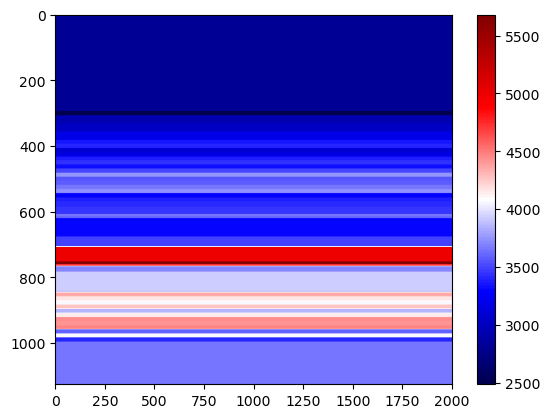

In [86]:
plt.imshow(vp, cmap='seismic', aspect="auto")
plt.colorbar()
plt.show()

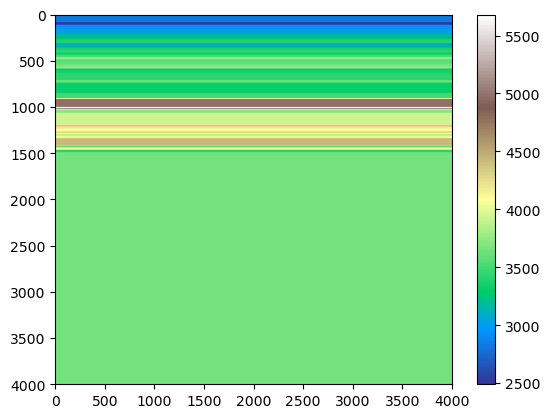

In [9]:
plt.imshow(unshifted_vp, extent=[0,4000,4000,0], cmap='terrain', aspect="auto")
plt.colorbar()
plt.show()

To save the grids, to an output folder, use `.save_modelling_grids()` method

In [87]:
# these generate grid files with defaults
forward.save_modelling_grids(offset = 500) 
baseline.save_modelling_grids(offset = 500)

In [14]:
import zener as zn

In [16]:
gi = zn.Grid_Info(parmsfile='parms.xlsx')

In [23]:
gi

In [88]:
forward.create_modelling_grids(offset = 500)["a11"]

array([[ 7952400.,  7952400.,  7952400., ...,  7952400.,  7952400.,
         7952400.],
       [ 7952400.,  7952400.,  7952400., ...,  7952400.,  7952400.,
         7952400.],
       [ 7952400.,  7952400.,  7952400., ...,  7952400.,  7952400.,
         7952400.],
       ...,
       [13395600., 13395600., 13395600., ..., 13395600., 13395600.,
        13395600.],
       [13395600., 13395600., 13395600., ..., 13395600., 13395600.,
        13395600.],
       [13395600., 13395600., 13395600., ..., 13395600., 13395600.,
        13395600.]], dtype=float32)

In [ ]:
with open('./input_data/balgonie_dataset.bin','rb') as f:
    depth = np.fromfile(f,dtype=np.dtype('int32'),count=1)[0]
    dims = np.fromfile(f,dtype=np.dtype('int32'),count=depth)
    total_elements = (lambda x,y:x*y)(*dims)
    data =np.reshape(np.fromfile(f,dtype=np.dtype('float64'), count=total_elements),dims)

In [138]:
import numpy as np
with open('./traces/Vx.bin','rb') as f:
    owt = np.fromfile(f,dtype=np.dtype('float32'),)

In [139]:
import matplotlib.pyplot as plt
tr = np.reshape(owt, (20001,9*99+76))

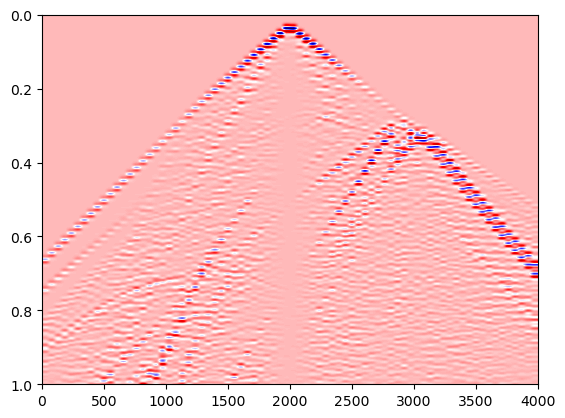

In [143]:
norm = tr[:,:76] / (.00001 + np.linalg.norm(tr[:,:76], axis=0, keepdims=True))
plt.imshow(norm, extent=[0,4000,1,0], cmap='seismic', aspect="auto")

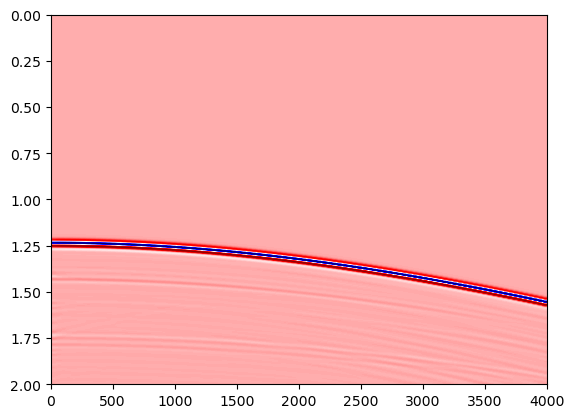

In [146]:
i=1
norm = tr[:,(i-1)*99+76:i*99+76] / (.00001 + np.linalg.norm(tr[:,(i-1)*99+76:i*99+76], axis=0, keepdims=True))
plt.imshow(norm, extent=[0,4000,2,0], cmap='seismic', aspect="auto")

In [71]:
with open('./snapshots/P-0000000.bin','rb') as f:
    owt = np.fromfile(f,dtype=np.dtype('float32'),)

In [75]:
tr = np.reshape(owt, (2001,1001))

In [79]:
252.0*np.arange(1,10)

array([ 252.,  504.,  756., 1008., 1260., 1512., 1764., 2016., 2268.])

In [150]:
model = np.load("/Users/gpapageo/Downloads/viscoelastic_vti_constantQ/model_pml/vp0_model.npy")

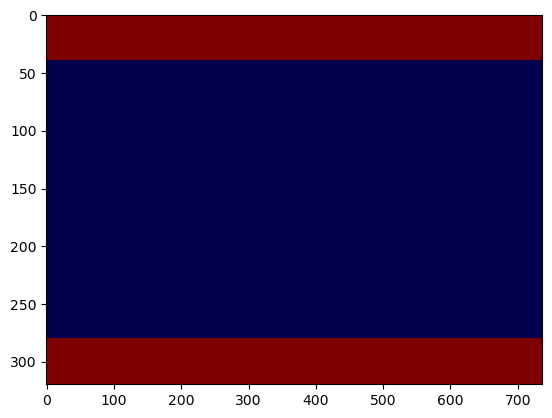

In [152]:
plt.imshow(model, cmap='seismic', aspect="auto")